# Hankel Alternative View of Koopman

HAVOK combines delay embedding and Koopman theory to decompose chaotic dynamics into
a linear model in the leading delay coordinates with forcing by low-energy delay
coordinates; this is called the Hankel alternative view of Koopman (HAVOK) analysis.
The method is illustrated on the chaotic Lorenz system (see Brunton, Brunton,
Proctor, Kaiser & Kutz, _"Chaos as an intermittently forced linear system"_, Nature
Communications 8(19), 2017):

$$\dot{x}_{1} = \sigma (x_2-x_1),\\
\dot{x}_2 = x_1(\rho-x_3)-x_2,\\
\dot{x}_3 = x_1x_2-\beta x_3$$

with parameters $\sigma=10$, $\rho=28$, and $\beta=8/3$.

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pykoopman as pk
from pykoopman.common import lorenz

Collect training data:

(-1.0, 100.0)

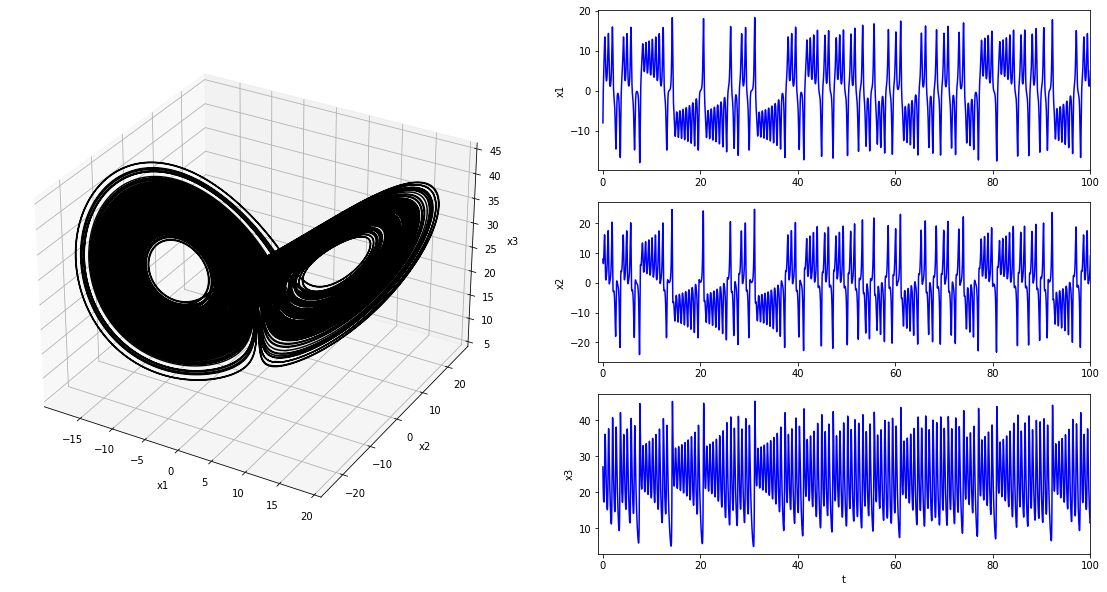

In [2]:
n_states = 3
x0 = [-8, 8, 27]  # initial condition
dt = 0.001  # timestep
t = np.linspace(dt, 200, 200000)  # time vector
x = integrate.odeint(lorenz, x0, t, atol=1e-12, rtol=1e-12)  # integrate ode

fig = plt.figure(figsize=(30,10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:, 0], projection='3d')
ax1.plot3D(x[:, 0], x[:, 1], x[:, 2], '-k')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.grid()
ax2a = fig.add_subplot(gs[0, 1])
ax2a.plot(t, x[:, 0], '-b', label='x')
ax2a.set_ylabel('x1')
ax2a.set_xlim([-1, 100])
ax2b = fig.add_subplot(gs[1, 1])
ax2b.plot(t, x[:, 1], '-b', label='y')
ax2b.set_ylabel('x2')
ax2b.set_xlim([-1, 100])
ax2c = fig.add_subplot(gs[2, 1])
ax2c.plot(t, x[:, 2], '-b', label='z')
ax2c.set_ylabel('x3')
ax2c.set_xlabel('t')
ax2c.set_xlim([-1, 100])

### HAVOK regression
The chaotic system is now modeled as a linear model in the leading delay coordinates,
 ${\bf v}:=[v_1, v_2, \ldots, v_{r-1}]^T$, with forcing by the low-energy, $r$th delay
  coordinate:
$$\dot{\bf v}(t) = {\bf A}{\bf v}(t) + {\bf B} v_r(t)$$.

The observables chosen for the HAVOK model are time-delay coordinates of the first
state coordinate $x(t)$. The resulting data matrix is referred to as Hankel matrix.
The number of delays is chosen to be $100$. The HAVOK model computes a SVD of the
Hankel matrix:
$${\bf H} = {\bf U}{\bf \Sigma}{\bf V}^{*}.$$
In order to regress on the V's delay coordinates, the corresponding time derivative
(i.e. $\dot{\bf v}$) must be first estimated, e.g. using the 4th order central
difference scheme. pyKoopman integrates the package [derivative](https://derivative
.readthedocs.io/en/latest/?badge=latest) for differentiation, which provides a large
suite of differentiation options for both clean and noisy data.

In [3]:
n_delays = 100-1
TDC = pk.observables.TimeDelay(delay=1, n_delays=n_delays)
HAVOK = pk.regression.HAVOK(svd_rank=15)
Diff = pk.differentiation.Derivative(kind='finite_difference', k=2)  # 4th order
# central difference

model = pk.KoopmanContinuous(observables=TDC, differentiator=Diff, regressor=HAVOK)
model.fit(x[:, 0], dt=dt)  # Compute model fit using training data

KoopmanContinuous(differentiator=Derivative(k=2, kind='finite_difference'),
                  observables=TimeDelay(n_delays=99),
                  regressor=HAVOK(svd_rank=15))

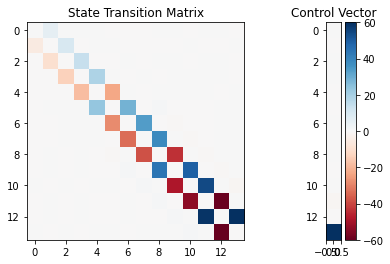

In [4]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(model.state_transition_matrix, aspect='equal', cmap=plt.get_cmap('RdBu'),
           vmin=-60, vmax=60)
ax0.set(title='State Transition Matrix')

ax1 = plt.subplot(gs[1])
im = ax1.imshow(model.control_matrix[:, np.newaxis], aspect='equal', cmap=plt.get_cmap
('RdBu'), vmin=-60, vmax=60)
ax1.set(title='Control Vector')
fig.colorbar(im, ax=ax1)

### Extract forcing signal
which corresponds to the rth delay vector, here $v_{14}$. The bursts correspond to
lobe switching events of the chaotic Lorenz system.

(-0.04, 0.04)

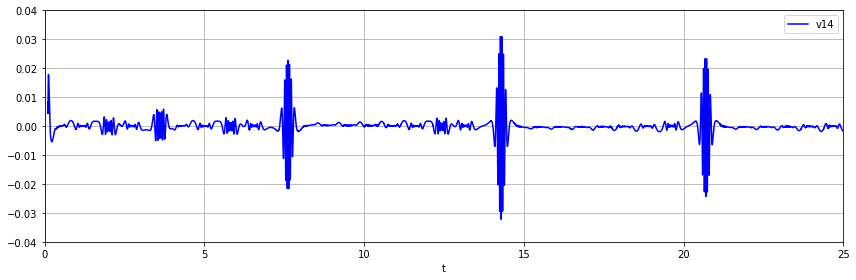

In [5]:
u = model.regressor.forcing_signal

fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
axs.plot(t[n_delays:], u, '-b', label='v14')
axs.grid()
axs.set_xlabel('t')
axs.legend(loc='best')
plt.xlim([0, 25])
plt.ylim([-.04, .04])

### Prediction using the HAVOK model
Using the identified model with the forcing signal $u=v_{14}$, it is possible to
reconstruct the attractor. The figure below shows the reconstructed variable $x(t)$
based on the model prediction of the dominant delay coordinates. In practice, it is
possible to measure $v_{14}$ from a streaming time series of $x(t)$ by convolution
with the $u_{14}$ mode (14th column in the matrix U), which can be accessed via `model.projection_matrix_`.

In [6]:
xpred = model.predict(x[:n_delays+1, 0], t[n_delays:]-t[n_delays], u)

(-20.0, 20.0)

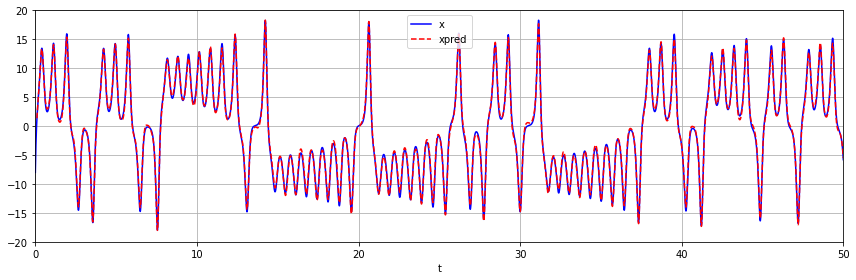

In [7]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
axs.plot(t, x[:, 0], '-b', label='x')
axs.plot(t[n_delays:], np.squeeze(xpred), '--r', label='xpred')
axs.grid()
axs.set_xlabel('t')
axs.legend(loc='best')
plt.xlim([0, 50])
plt.ylim([-20, 20])